# Breast Cancer

This dataset is from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+diagnostic).

This dataset is relatively small with only 569 rows. According to the description, the data can be seperated by a plane in the 3-dimensional space with the Multisurface Method-Tree. It will be interesting to see how this property affect the classifiers performance.

The dataset is also not balanced. There are 357 benign and 212 malignant cases. Given that the data set is lineraly seperable, it shouldn't be a problem from SVM and Neural Network, however it could cause some problem for k-NN and Boosting.


In [1]:
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True

## Setup

First, we load all the packages required for running the five algorithms and analyzing their performance.


In [2]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn import base
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from scipy.io import arff

from typing import Any
from typing import Union

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing



This dataset from UCI Data Repository has already been cleaned up and has no unknown values.

- Use the `preprocessing.OrdinalEncoder` module to encode the **Class** column
- Scale the features
- Split the data into **Training** and **Test** sets


In [3]:
data = pd.read_csv('data/breast-cancer-wisconsin.data')
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

features = preprocessing.scale(data.drop(['diagnosis'], axis=1))
target = data["diagnosis"]

print(f"Number of samples: {target.size}")
print(
    f"Percentage of Malignment: {target.value_counts(normalize=True)['M'] * 100:.3f}%")
print(
    f"Percentage of Benign: {target.value_counts(normalize=True)['B'] * 100:.3f}%")

data["diagnosis"] = preprocessing.OrdinalEncoder().fit_transform(data[["diagnosis"]])
target = data["diagnosis"].astype(int)

print("Splitting into train/test sets...", end="")
FEATURES_TRAIN, FEATURES_TEST, TARGET_TRAIN, TARGET_TEST = train_test_split(
    features, target, test_size=0.3, random_state=42)
print("Done")

print("Setting up global variables...", end="")
classifier_accuracy = np.zeros(6)
train_time = np.zeros(6)
infer_time = np.zeros(6)
print("Done")


Number of samples: 569
Percentage of Malignment: 37.258%
Percentage of Benign: 62.742%
Splitting into train/test sets...Done
Setting up global variables...Done


## Helper Functions & Global Variables


In [4]:
TARGET_CLASSES = ['B', 'M']


def plot_confusionmatrix(predicted, expected, dom) -> None:
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(predicted, expected)
    sns.heatmap(cf, annot=True, yticklabels=TARGET_CLASSES,
                xticklabels=TARGET_CLASSES, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


In [5]:
ClassifierMixin = Union[DecisionTreeClassifier, MLPClassifier,
                        AdaBoostClassifier, SVC, KNeighborsClassifier]


def default_fit_test(classifier: ClassifierMixin) -> None:
    classifier.fit(FEATURES_TRAIN, TARGET_TRAIN)

    train_pred = classifier.predict(FEATURES_TRAIN)
    test_pred = classifier.predict(FEATURES_TEST)

    print(f'Train score {accuracy_score(train_pred, TARGET_TRAIN)}')
    print(f'Test score {accuracy_score(test_pred, TARGET_TEST)}')
    plot_confusionmatrix(train_pred, TARGET_TRAIN, dom='Train')
    plot_confusionmatrix(test_pred, TARGET_TEST, dom='Test')


In [6]:
def grid_search_and_best_fit(classifier: ClassifierMixin, param_grid: dict[str, Any], index: int, name: str) -> GridSearchCV:
    classifier_best = GridSearchCV(
        classifier, param_grid=param_grid, cv=4)

    start_time = time.time()
    classifier_best.fit(FEATURES_TRAIN, TARGET_TRAIN)
    end_time = time.time()
    train_time[index] = end_time - start_time
    print(f"Best params for {name}: {classifier_best.best_params_}")

    return classifier_best


In [7]:
def best_fit_test(classifier_best: GridSearchCV, index: int, name: str) -> None:
    best_train_pred = classifier_best.predict(FEATURES_TRAIN)
    print(
        f"Accuracy for best {name} on train sets: {accuracy_score(TARGET_TRAIN, best_train_pred)}")
    start_time = time.time()
    best_test_pred = classifier_best.predict(FEATURES_TEST)
    classifier_accuracy[index] = accuracy_score(TARGET_TEST, best_test_pred)
    end_time = time.time()
    infer_time[index] = end_time - start_time
    print(
        f"Accuracy for best {name} on test sets: {classifier_accuracy[index]}")

    plot_confusionmatrix(best_train_pred, TARGET_TRAIN,
                         dom="Train Set with Best Params")
    plot_confusionmatrix(best_test_pred, TARGET_TEST,
                         dom="Test Set with Best Params")


In [8]:
def plot_learning_curve(classifier_learning: ClassifierMixin, name: str):
    _, train_scores, val_scores = learning_curve(
        classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

    plt.figure()
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
             np.mean(train_scores, axis=1), label='Train Score')
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
             np.mean(val_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title(f"Learning Curve ({name})")
    plt.xlabel("Percentage of Training Examples")
    plt.ylabel("Score")
    plt.xticks(np.linspace(0.1, 1.0, 10) * 100)
    plt.grid()
    plt.savefig(
        f"images/breast_cancer/breast_cancer_{'_'.join(name.lower().split(' '))}_learning_curve.png")
    plt.show()


In [9]:
def plot_validation_curve(
        classifier: ClassifierMixin, param_name: str,
        param_range: np.ndarray, name: str,
        xticks: np.ndarray = None, default_xticks: bool = False,
        xaxis_log: bool = False) -> None:
    train_scores, val_scores = validation_curve(
        classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name=param_name, param_range=param_range, cv=4)

    plt.figure()
    if xaxis_log:
        plt.semilogx(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.semilogx(param_range, np.mean(val_scores, axis=1), label='CV Score')
    else:
        plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.plot(param_range, np.mean(val_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title(f"Validation Curve ({name})")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    if default_xticks:
        pass
    elif xticks is not None:
        plt.xticks(xticks)
    else:
        plt.xticks(param_range)
    plt.grid()
    plt.savefig(
        f"images/breast_cancer/breast_cancer_{'_'.join(name.lower().split(' '))}_{param_name}_validation_curve.png")
    plt.show()


`scikit-learn` provides an intuitive interface for training and evaluating machine learning models. I will be using `validation_curve` and `GridSearchCV` to cross-validate over a range of hyper-parameter values to find the best model.


## Decision Tree


### Pretuning


Train score 1.0
Test score 0.9415204678362573
Train Confusion matrix


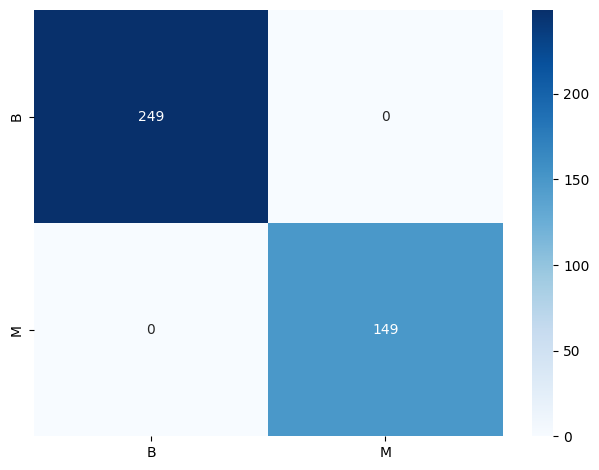

Test Confusion matrix


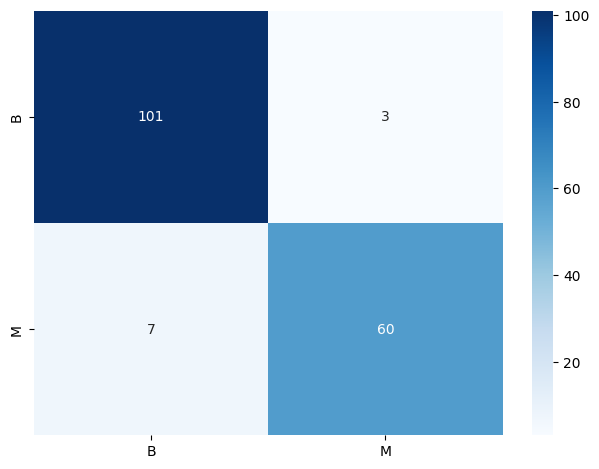

In [96]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
default_fit_test(decision_tree_classifier)


The above figures are the confusion matricies on the training set and testing set respectively of a Decision Tree Classifier with no pruning and no parameter tuning. The decision tree classifier can get 100% correct on the training set but merely 94% for the test set. This is a clear sign of overfitting. The decision tree is too complex and is not generalizing well.


### Tuning Maximum Depth and CCP-$\alpha$


To prevent over fitting, a maximum depth will be set as a pre-pruning method and CCP-$\alpha$ (Cost Complexity Pruning) will be used for post-pruning.

Two parameters will be tuned:

- `max_depth` for the tree maxium depth ranging from [1, 26)
- regularization parameter $\alpha$ for CCP ranging from [0, 0.1). A higher value of $\alpha$ will prune more nodes out of the tree.


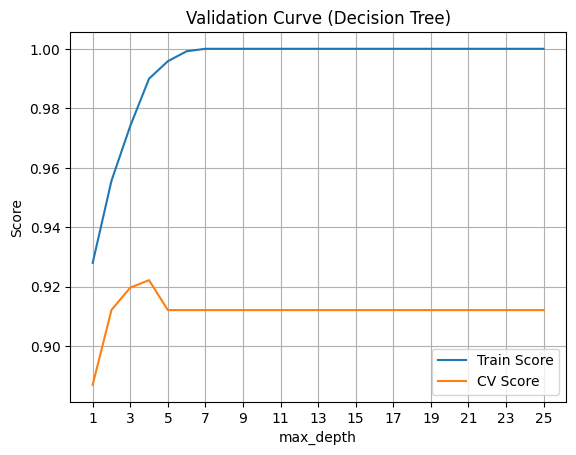

In [97]:
plot_validation_curve(
    decision_tree_classifier, 'max_depth',
    np.arange(1, 26), 'Decision Tree',
    np.arange(1, 26, 2))


The above figure is a cross-validation graph for `max_depth`. The training score converges to 1 as the maximum depth increases as the tree is getting more and more complex and can fit the training data perfectly. However, the validation score reaches its peak at a certain value and starts decreasing as overfitting starts kicking in.


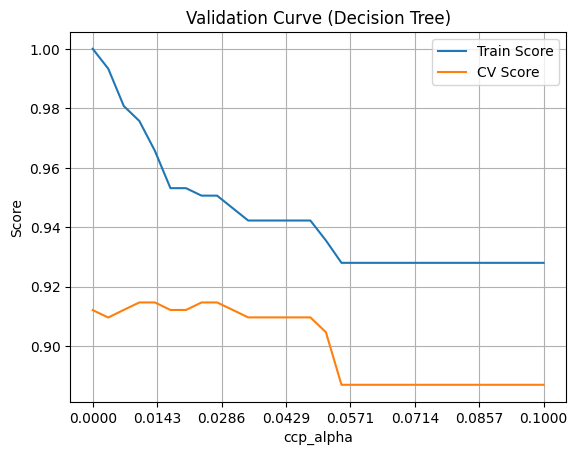

In [98]:
plot_validation_curve(
    decision_tree_classifier, 'ccp_alpha',
    np.linspace(0, 0.1, 30), 'Decision Tree',
    np.linspace(0, 0.1, 8))


From the figure above, we can see the relationship of CCP-$\alpha$ with train score and the cross validation score. The CV score reaches at its local maximum at a certain and then decreases along with the training score.


In [99]:
param_grid = {
    'max_depth': np.arange(1, 26),
    'ccp_alpha': np.linspace(0, 0.1, 30)
}
decision_tree_classifier_best = grid_search_and_best_fit(
    decision_tree_classifier, param_grid, 0, "decision tree")


Best params for decision tree: {'ccp_alpha': 0.003448275862068966, 'max_depth': 3}


Accuracy for best decision tree on train sets: 0.9698492462311558
Accuracy for best decision tree on test sets: 0.9649122807017544
Train Set with Best Params Confusion matrix


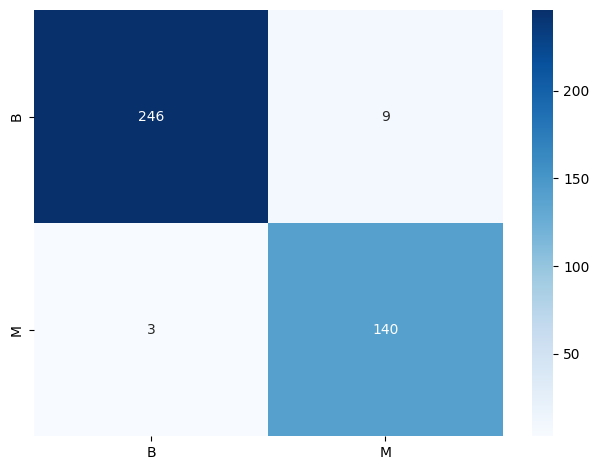

Test Set with Best Params Confusion matrix


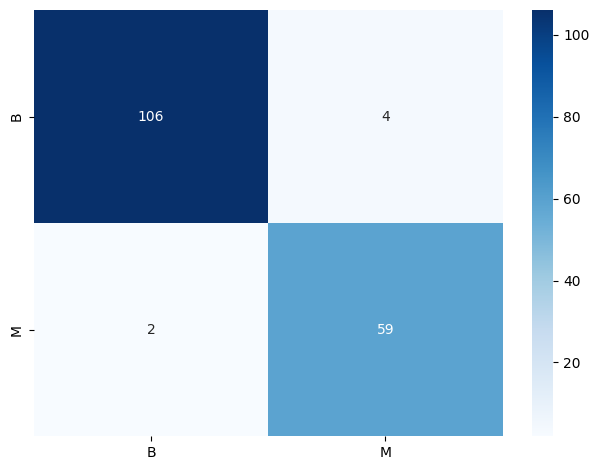

In [100]:
best_fit_test(decision_tree_classifier_best, 0, "decision tree")


The confusion matrix on training set and testing set are plotted again for comparison between the default parameter classfier and the bets parameter classifier. We can see that the accuracy score for the training set is not 100% anymore but the accuracy score for the testing set is improved by 2%. The relative high accuracy score on both training and testing set indicates that the classifier is a good fit.


### Deicision Tree Learning Curve


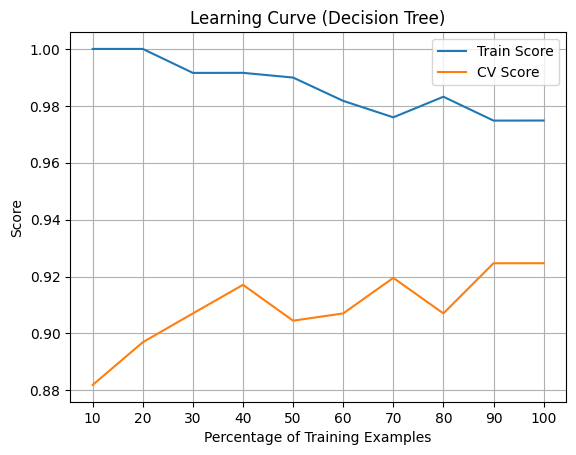

In [101]:
decision_tree_classifier_learning = DecisionTreeClassifier(
    random_state=42,
    max_depth=decision_tree_classifier_best.best_params_['max_depth'],
    ccp_alpha=decision_tree_classifier_best.best_params_['ccp_alpha']
)
plot_learning_curve(decision_tree_classifier_learning, "Decision Tree")


The gap between the train score and the CV score gets smaller and smaller when the percentage of training examples increases. However, the gap is still relatively big when it reaches 100%. This means that the data we have current is not sufficient or we need to choose a less complex model with fewer features.


## Neural Networks


### Multi-Layer Neural Network


#### Pretuning


Train score 0.9899497487437185
Test score 0.9883040935672515
Train Confusion matrix


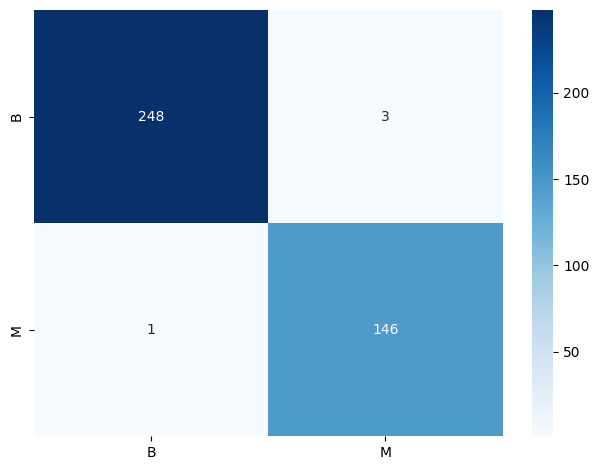

Test Confusion matrix


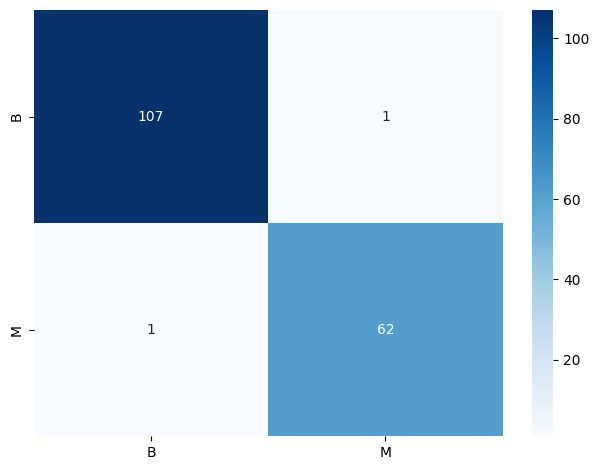

In [10]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4),
    random_state=42,
    max_iter=2000
)
default_fit_test(neural_network_classifier)


For the multi-layer neural network, a neural network with 2 4-node hidden layers is established. The activation function is ReLU and the solver is Adam. Compared to the decision tree, the multi-layer neural network is already performing better.


#### Tuning Regularization $\alpha$ and Initial Learning Rate


Two parameters will be tuned:

- regularization parameter $\alpha$ for L2 regularization ranging from $[10^{-3}, 10^{3})$.
- initial learning rate for the Adam optimizer ranging from [0.00001, 10)


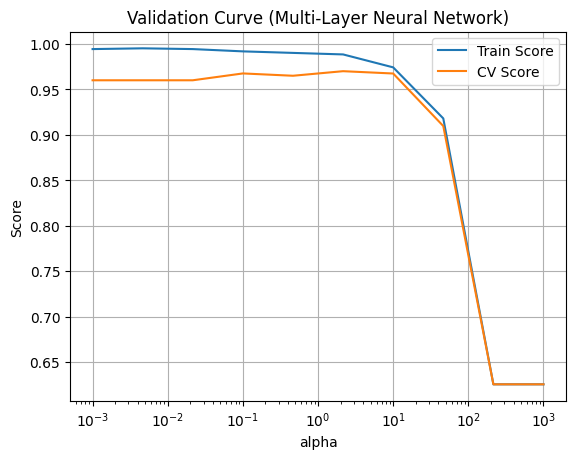

In [103]:
plot_validation_curve(
    neural_network_classifier, 'alpha',
    np.logspace(-3, 3, 10), "Multi-Layer Neural Network",
    default_xticks=True, xaxis_log=True)


Regularization adds the penalty as model complexity increases. The regularization parameter forces the weights to be small but does not make them zero and does not give the sparse solution to avoid overfitting. However, as the value gets bigger, it will lead to under-fitting. When alpha is 0, ridge regularization is equivalent to ordinary least squre ot OLS.

The above figure shows the underfitting nicely as both the training scores and the CV score starts to plummet as $\alpha$ exceeds a certain value.


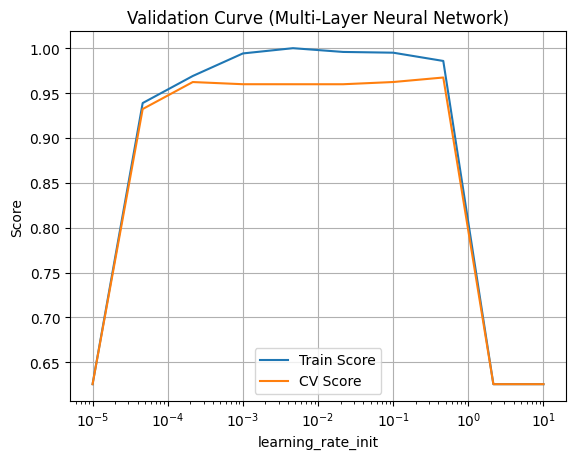

In [104]:
plot_validation_curve(
    neural_network_classifier, 'learning_rate_init',
    np.logspace(-5, 1, 10), "Multi-Layer Neural Network",
    default_xticks=True, xaxis_log=True)


The above figure can be separated into three different sections and they corresponds to the three differnt init learning rate period.

Just like gradient descent if the learning rate is too small, it will take a lot of iterations to find the local optimum. With a maximum of iterations set for the MLPClassifier, it's likely the model is not well-trained. This corresponds to the first section of the graph when the training score and CV score increases at the same time.

When the learning rate is just right, the model can be trained well within the iteration limit. This corresponds to the plateau of the graph.

However, when the learning rate is too big, drastic update can lead tp divergent behaviour which will lower the accuracy score. This corresponds to the third section of the graph when the training score and CV score starts to plummet.


In [11]:
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'learning_rate_init': np.logspace(-5, 1, 10)
}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 1, "multi-layer neural network")


Best params for multi-layer neural network: {'alpha': 2.154434690031882, 'learning_rate_init': 0.1}


Accuracy for best multi-layer neural network on train sets: 0.9899497487437185
Accuracy for best multi-layer neural network on test sets: 0.9941520467836257
Train Set with Best Params Confusion matrix


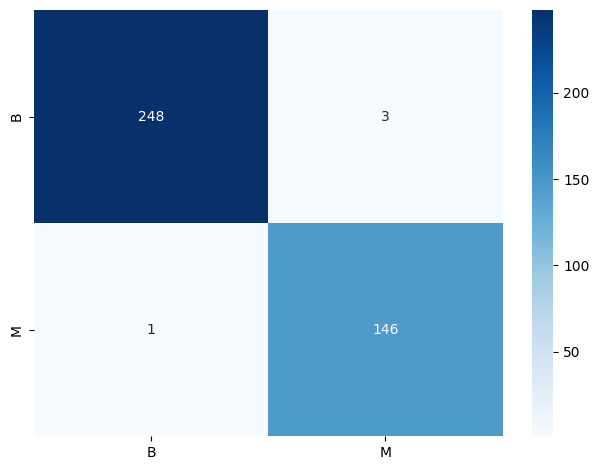

Test Set with Best Params Confusion matrix


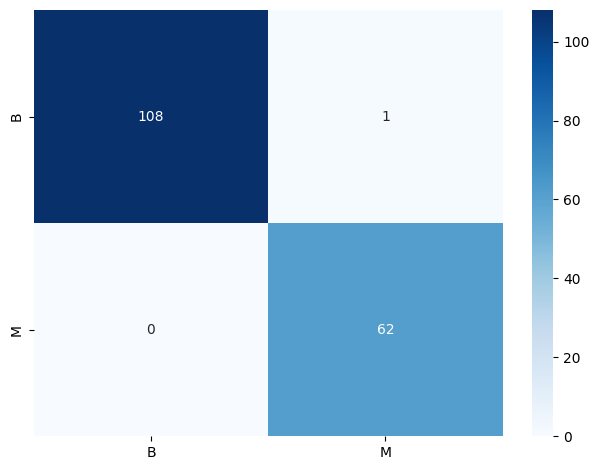

In [106]:
best_fit_test(neural_network_classifier_best, 1, "multi-layer neural network")


From the comparison between the confusion matrix with the best parameters and the default confusion matrix, not much improvement can be found. This is likely due to the fact that the default neural network classifier already has a high accuracy score and the dataset I have chosen has a small number of instances and they are linearly seperable.


#### Neural Network Learning Curve


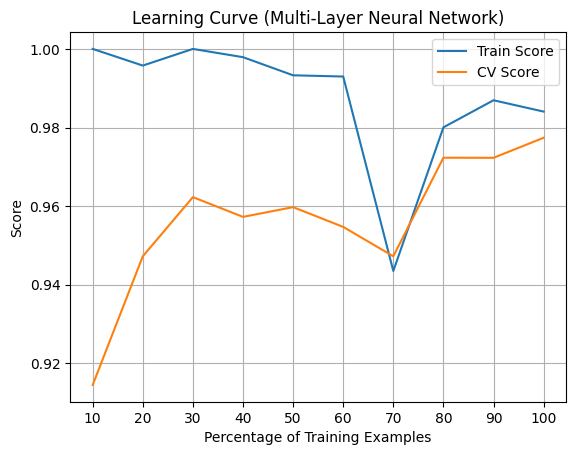

In [107]:
neural_network_classifier_learning = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000,
    learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'],
    alpha=neural_network_classifier_best.best_params_['alpha'])
plot_learning_curve(neural_network_classifier_learning,
                    "Multi-Layer Neural Network")


From the learning curve, we can see that the training score and the CV score remains relatively high and converges when the percentage of training examples increases. This suggests that the neural network could potentially be a good classifier since the dataset has low bias and low variance.

### Training Loss and Score


Using the same hyper parameter, the loss curve which shows how error is reduced as the epochs keeps increasing during training is also plotted for the training set and the test set.

In [12]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=1,
    alpha=neural_network_classifier_best.best_params_['alpha'],
    learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'],
    warm_start=True
)
epochs = 300
training_loss = np.zeros(epochs)
validation_loss = np.zeros(epochs)
training_score = np.zeros(epochs)
validation_score = np.zeros(epochs)

features_train_train, features_train_val, target_train_train, target_train_val = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
for epoch in range(epochs):
    neural_network_classifier.fit(features_train_train, target_train_train)

    training_score[epoch] = accuracy_score(
        target_train_train, neural_network_classifier.predict(features_train_train))
    training_loss[epoch] = neural_network_classifier.loss_

    validation_score[epoch] = accuracy_score(
        target_train_val, neural_network_classifier.predict(features_train_val))
    validation_loss[epoch] = neural_network_classifier.loss_

test_score = accuracy_score(
    TARGET_TEST, neural_network_classifier.predict(FEATURES_TEST))
print("Test set accuracy:", test_score)


Test set accuracy: 0.9649122807017544


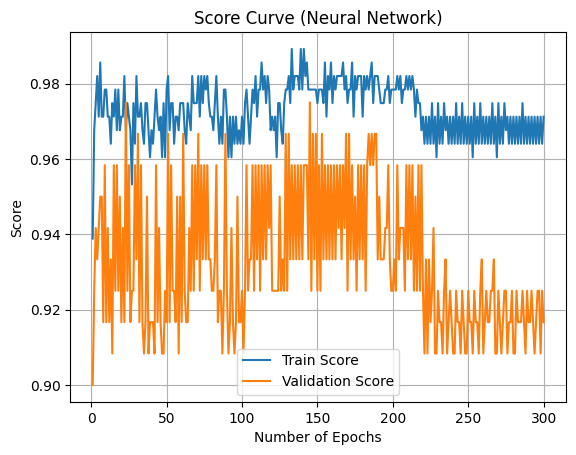

In [13]:
plt.figure()
plt.plot(np.arange(epochs) + 1, training_score, label='Train Score')
plt.plot(np.arange(epochs) + 1, validation_score, label='Validation Score')
plt.legend()
plt.title("Score Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.grid()
plt.savefig('images/breast_cancer/breast_cancer_neural_network_score_curve.png')
plt.show()


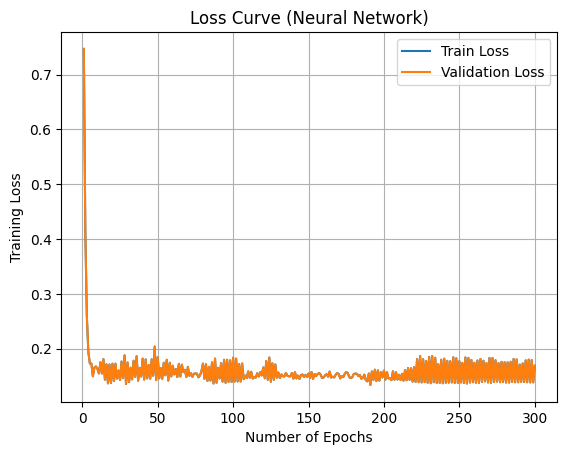

In [14]:
plt.figure()
plt.plot(np.arange(epochs) + 1, training_loss, label='Train Loss')
plt.plot(np.arange(epochs) + 1, validation_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.grid()
plt.savefig('images/breast_cancer/breast_cancer_neural_network_loss_curve.png')
plt.show()


The training loss keeps decreasing with increasing number of epochs. The high training and validation scores showcase the good performance of the neural network classifier even after 300 epochs.

However, there are some oscillations in the training loss curve and the score curve. This is likely due to the fact that the dataset is small and the neural network is very sensitive to noise.


### Single-Layer Neural Network


#### Pretuning


Train score 0.9949748743718593
Test score 0.9766081871345029
Train Confusion matrix


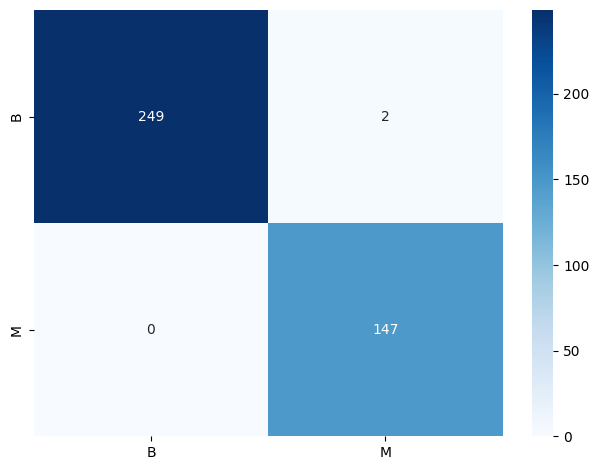

Test Confusion matrix


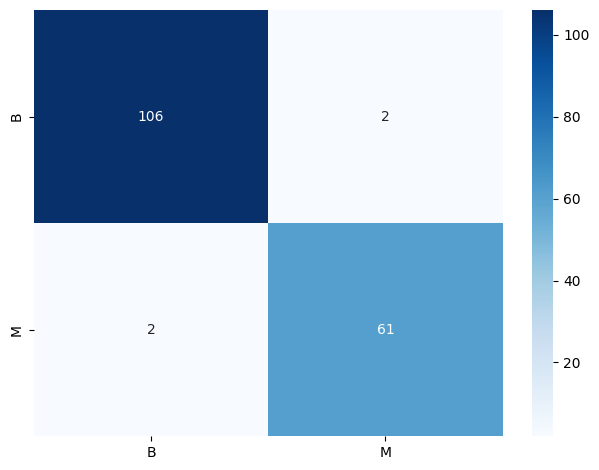

In [111]:
neural_network_classifier = MLPClassifier(random_state=42, max_iter=2000)
default_fit_test(neural_network_classifier)


Here I established a base case for a single-layer neural network. In this case the neural network will only have 1 layer but there will be multiple neurons on that layer.


#### Tuning Regularization $\alpha$ and Hidden Layer Sizes


Two parameters will be tuned:

- regularization parameter $\alpha$ for L2 regularization ranging from $[10^{-3}, 10^3)$.
- hidden layer sizes ranging from [2, 31]


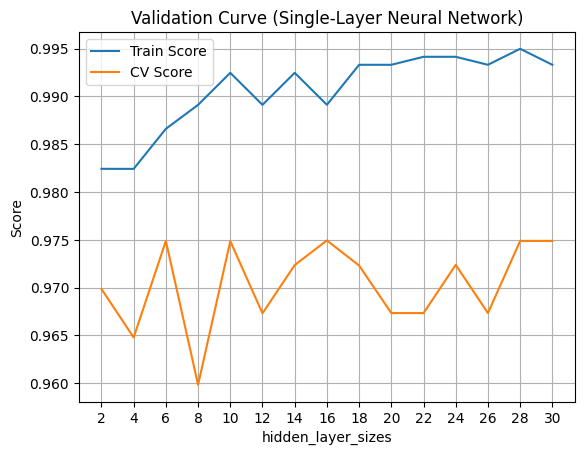

In [112]:
plot_validation_curve(
    neural_network_classifier, 'hidden_layer_sizes',
    np.arange(2, 31, 2), "Single-Layer Neural Network")


The Corss Validation curve for the `hidden_layer_sizes` is also interesting as the CV score seems to be changing dramatically as the number of nodes increases.

Normally, I would blame this observation on the noise in the dataset, but i think here it's just the scale of the y-axis that exaggerates the difference.


In [113]:
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'hidden_layer_sizes': np.arange(2, 31, 2)
}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 2, "single layer neural network")


Best params for single layer neural network: {'alpha': 2.154434690031882, 'hidden_layer_sizes': 16}


It looks like the single-layer NN and the Multi-layer NN performs similarly in this case as they have the same $\alpha$.


Accuracy for best single layer neural network on train sets: 0.9874371859296482
Accuracy for best single layer neural network on test sets: 0.9941520467836257
Train Set with Best Params Confusion matrix


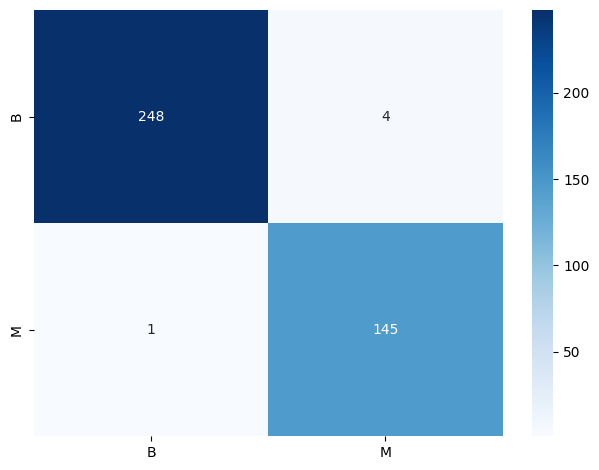

Test Set with Best Params Confusion matrix


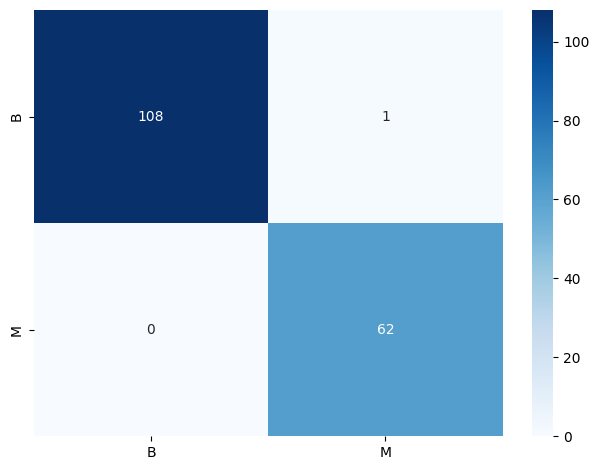

In [114]:
best_fit_test(neural_network_classifier_best, 2, "single layer neural network")


#### Nerual Network Learning Curve


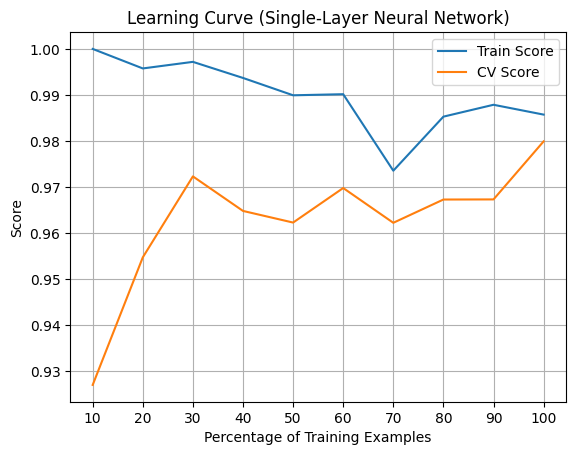

In [115]:
neural_network_classifier_learning = MLPClassifier(
    random_state=42, max_iter=2000,
    hidden_layer_sizes=neural_network_classifier_best.best_params_['hidden_layer_sizes'],
    alpha=neural_network_classifier_best.best_params_['alpha'])
plot_learning_curve(neural_network_classifier_learning,
                    "Single-Layer Neural Network")


The learning curve of the single-layer neural network also shows a strong trend of convergence as the multi-layer neural network does. This suggests that it may also be a good fit for this dataset as well.


## Boosting


### Pretuning


Train score 1.0
Test score 0.9766081871345029
Train Confusion matrix


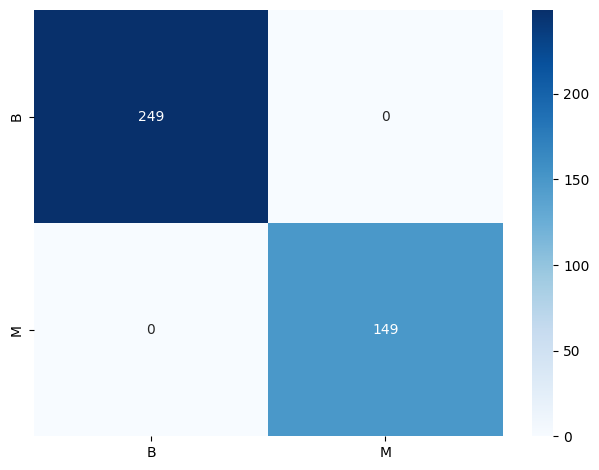

Test Confusion matrix


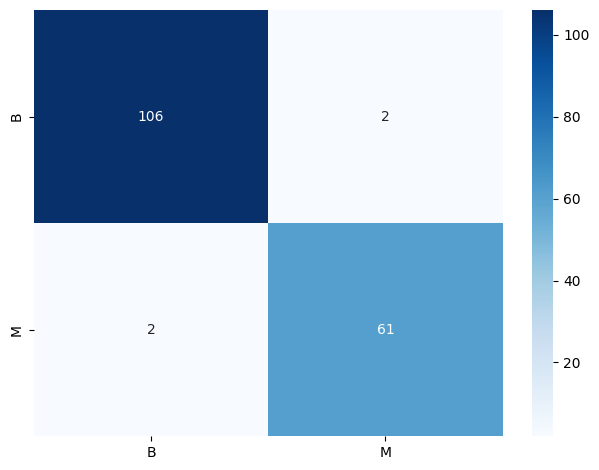

In [116]:
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
    max_depth=1, min_samples_leaf=1), random_state=42)
default_fit_test(adaboost_classifier)


The boosting classifier here is using a single leaf decision tree as a weak learner as this is a binary classification problem.


### Tuning N-Estimators and Learning Rate


Parameters to be tuned:

- n_estimators ranging from [1, 2500]
- learning rate ranging from $[10^{-5}, 10)$


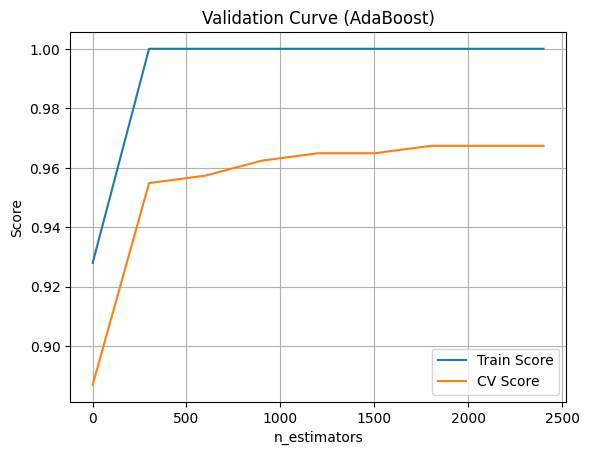

In [117]:
plot_validation_curve(
    adaboost_classifier, 'n_estimators',
    np.arange(1, 2500, 300), "AdaBoost",
    default_xticks=True)


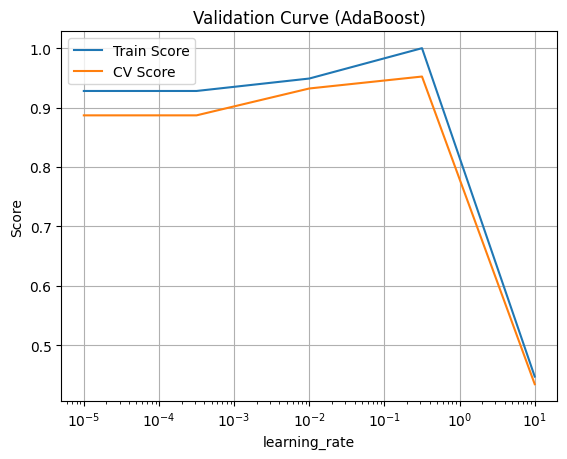

In [118]:
plot_validation_curve(
    adaboost_classifier, 'learning_rate',
    np.logspace(-5, 1, 5), "AdaBoost",
    default_xticks=True, xaxis_log=True)


The learning rate validation curve should be similar to the `learning_rate_init` validation curve from the neural network, as boosting also uses methods similar to gradient descent to approach the local optima. However only 2 different behvaiour is observed and this is likely due to the fact that the lower bound of the serach space is large enough to avoid the underfitting behaviour.


In [119]:
param_grid = {
    'learning_rate': np.logspace(-5, 1, 5),
    'n_estimators': np.arange(1, 2500, 300)
}
adaboost_classifier_best = grid_search_and_best_fit(
    adaboost_classifier, param_grid, 3, "adaboost")


Best params for adaboost: {'learning_rate': 0.31622776601683794, 'n_estimators': 2401}


Accuracy for best adaboost on train sets: 1.0
Accuracy for best adaboost on test sets: 0.9824561403508771
Train Set with Best Params Confusion matrix


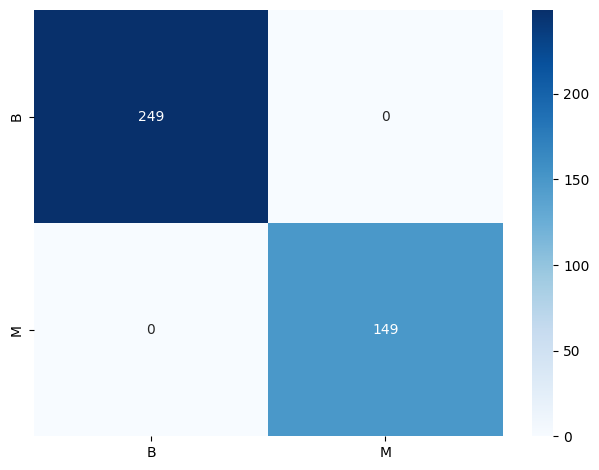

Test Set with Best Params Confusion matrix


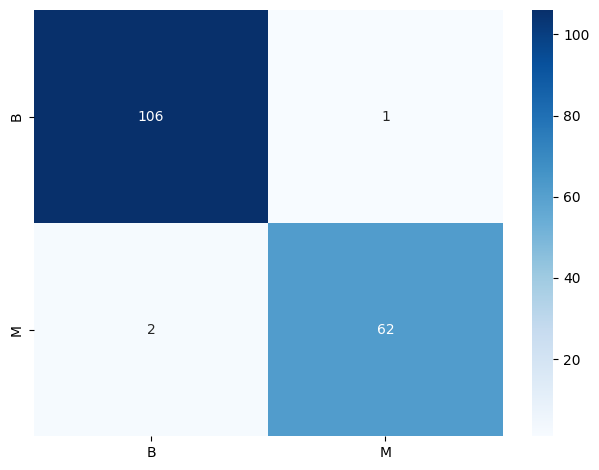

In [120]:
best_fit_test(adaboost_classifier_best, 3, "adaboost")


### Adaboost Learning Curve


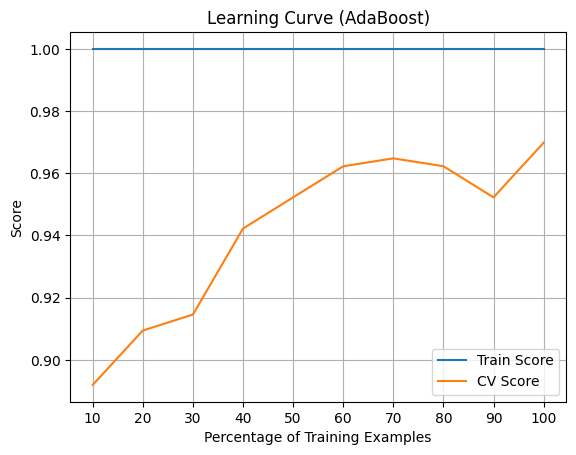

In [121]:
adaboost_classifier_learning_curve = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
    max_depth=1, min_samples_leaf=1), random_state=42,
    n_estimators=adaboost_classifier_best.best_params_['n_estimators'],
    learning_rate=adaboost_classifier_best.best_params_['learning_rate'])
plot_learning_curve(adaboost_classifier_learning_curve, "AdaBoost")


The learning curve for the Adaboost is quite intersting as the train score remains at 100% while the CV score keeps increasing. This supports the fact that boosting classifier is less likely to overfit and the more data it learns, the better it performs. However, the gap between the train score and the CV score is still relatively big. This suggests that the classifier needs more data.


## SVM


### Pretuning


Train score 0.9899497487437185
Test score 0.9766081871345029
Train Confusion matrix


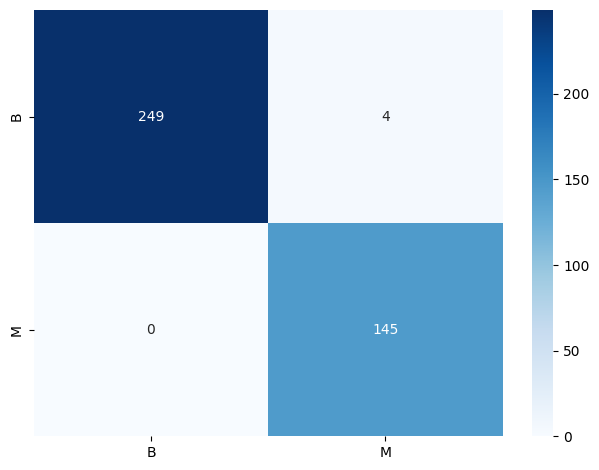

Test Confusion matrix


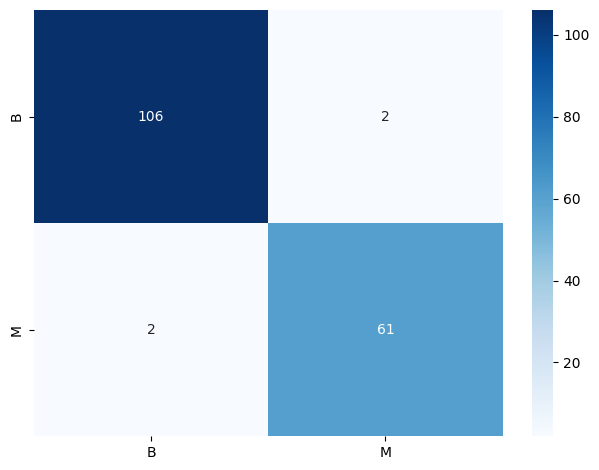

In [122]:
svm_classifier = SVC(kernel='linear', random_state=42)
default_fit_test(svm_classifier)


With default setup, the SVM classifier uses an rbf kernel and a C value of 1.0. The SVC with default setup can achieve an accruacy score of 97.6%.


### Tuning Regularization C and Kernel Method


Parameters to be tuned:

- C ranging from $[10^{-3}, 10^{3})$
- kernel method ranging from ['linear', 'poly', 'rbf', 'sigmoid']


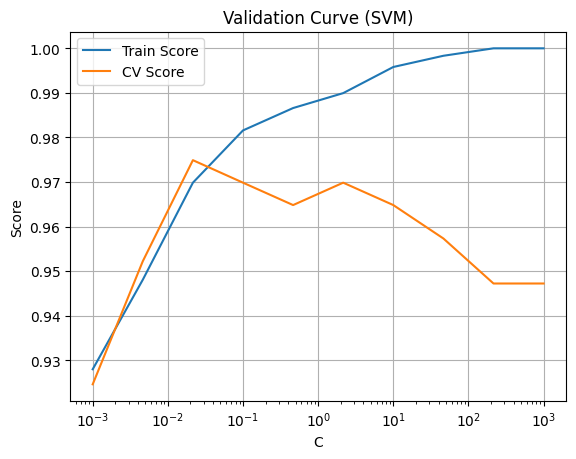

In [123]:
plot_validation_curve(
    svm_classifier, 'C',
    np.logspace(-3, 3, 10), "SVM",
    default_xticks=True, xaxis_log=True)


The train score and the CV score of hyper parameter C diverges dramatically after a certain value. This shows that SVM is suffering from overfitting from that point onwards.


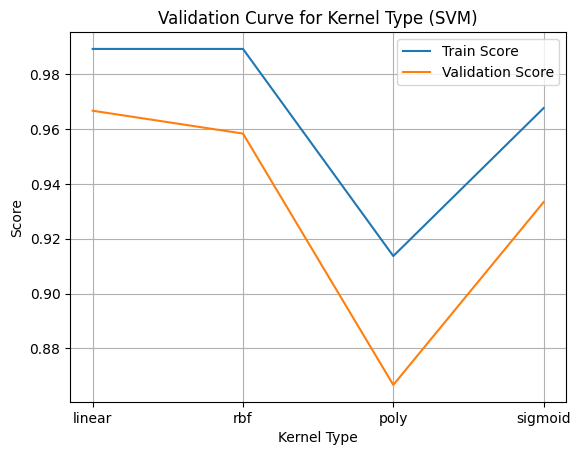

In [124]:
train_scores = np.zeros((4, 1))
test_scores = np.zeros((4, 1))

svm_classifier = svm.SVC(random_state=42, kernel='linear')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[0] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[0] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='rbf')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[1] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[1] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='poly')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[2] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[2] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='sigmoid')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[3] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[3] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

plt.figure()
plt.plot(np.arange(0, 4), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(0, 4), np.mean(
    test_scores, axis=1), label='Validation Score')
plt.legend()
plt.title("Validation Curve for Kernel Type (SVM)")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(4), ['linear', 'rbf', 'poly', 'sigmoid'])
plt.savefig('images/breast_cancer/breast_cancer_svm_kernel_validation_curve.png')
plt.show()


It's quite evident that the linear model has the bets CV score. This could indicate that the dataset is linearly separable.


In [125]:
param_grid = {
    'C': np.logspace(-3, 3, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
svm_classifier_best = grid_search_and_best_fit(
    svm_classifier, param_grid, 4, "SVM")


Best params for SVM: {'C': 0.021544346900318832, 'kernel': 'linear'}


Accuracy for best SVM on train sets: 0.9773869346733668
Accuracy for best SVM on test sets: 0.9883040935672515
Train Set with Best Params Confusion matrix


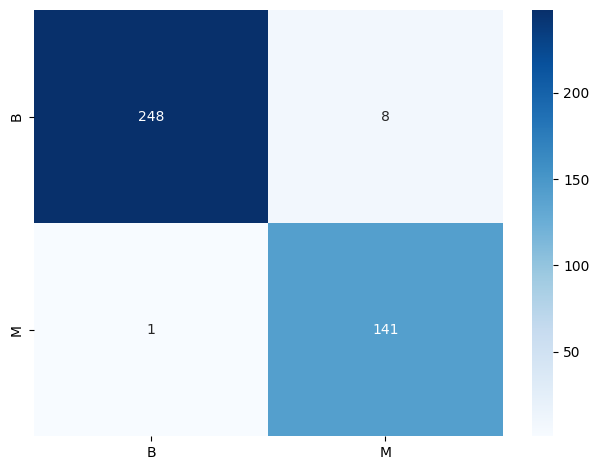

Test Set with Best Params Confusion matrix


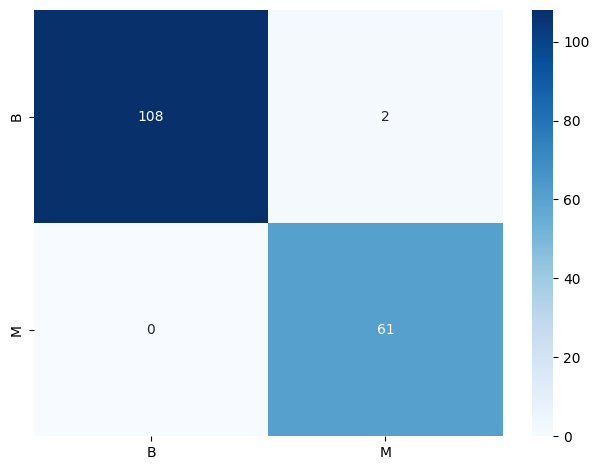

In [126]:
best_fit_test(svm_classifier_best, 4, "SVM")


With the best parameters, the SVM classifier improves on both the training score and the testing score which is the only one out of the five different classifiers.

### SVM Learning Curve


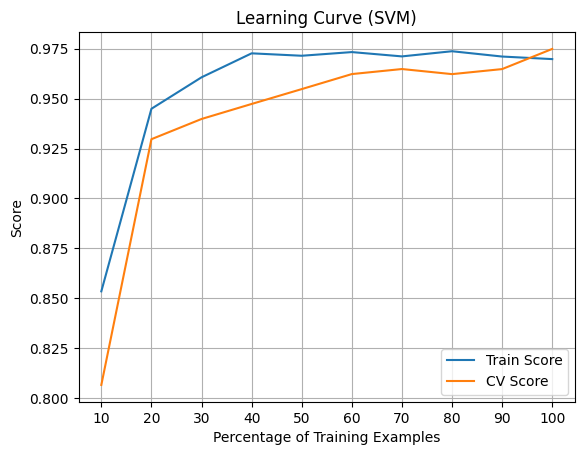

In [127]:
svm_classifier_learning = svm.SVC(
    random_state=42, C=svm_classifier_best.best_params_['C'],
    kernel=svm_classifier_best.best_params_['kernel'])
plot_learning_curve(svm_classifier_learning, "SVM")


From the learning curve, the train score and CV score converges at a high percentage of training examples. This shows that the SVM is performing well without bias or variance issues. The dataset could be linearly sperable.


## k-Nearest Neighbors


### Pretuning


Train score 0.9773869346733668
Test score 0.9590643274853801
Train Confusion matrix


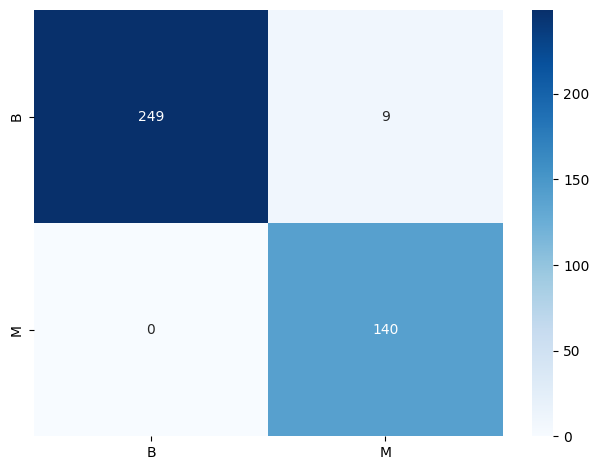

Test Confusion matrix


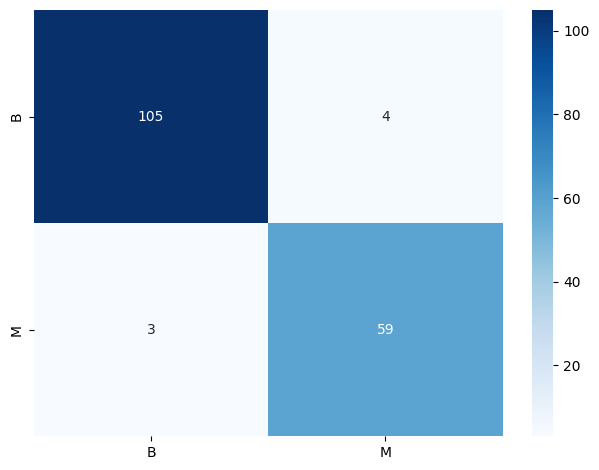

In [128]:
knn_classifier = KNeighborsClassifier()
default_fit_test(knn_classifier)


Before any study is done, a base case for the k-Nearest Neighbour Classifier should be established, that is a k-NN Classifier without tuning the number of neighbours and the power parameter of the Minkowski distance function. From what the confusion matrix is showing, the training score and the CV score is already pretty close to each other with the default case (n_neighbors=5, p=2).


### Tune Number of Neighbors & Minkowski Power Parameter


Parameters to be tuned:

- n_neighbors ranging from [1, 201]
- p ranging from [1, 10]


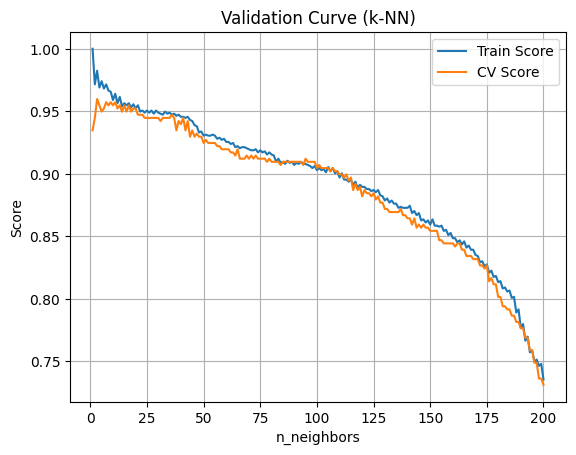

In [129]:
plot_validation_curve(
    knn_classifier, 'n_neighbors',
    np.arange(1, 201), "k-NN",
    default_xticks=True)


The above image shows the relationship of the training score and the CV score with the number of neighbours. The CV score reaches its maximum when the number of neighbours at a certain value and then starts to decrease together with the training score. The reason is likely to be the bias in the model which keeps increasing as the number of neighbours increases. Essentially, when the k is too small, it's more likely to overfit since the classifier is very sensitive to anomalies whereas when the k is too big, the classifier is going to underfit since it' slowly ignoring the local particularities.


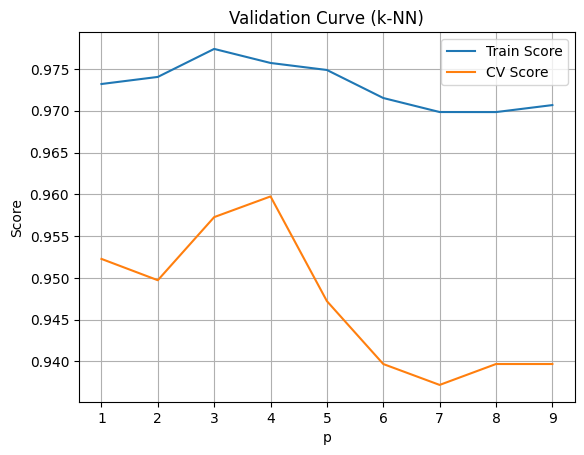

In [130]:
plot_validation_curve(knn_classifier, 'p', np.arange(1, 10), "k-NN")


The above image shows the relationship of the training score and the CV score when tuning the power parameter for the Minkowski distance function. The CV score reaches its maximum when the power parameter is 4 and then starts to decrease.


In [131]:
param_grid = {
    'n_neighbors': np.arange(1, 201),
    'p': np.arange(1, 10)
}
knn_classifier_best = grid_search_and_best_fit(
    knn_classifier, param_grid, 5, "k-NN")


Best params for k-NN: {'n_neighbors': 3, 'p': 1}


Accuracy for best k-NN on train sets: 0.9899497487437185
Accuracy for best k-NN on test sets: 0.9707602339181286
Train Set with Best Params Confusion matrix


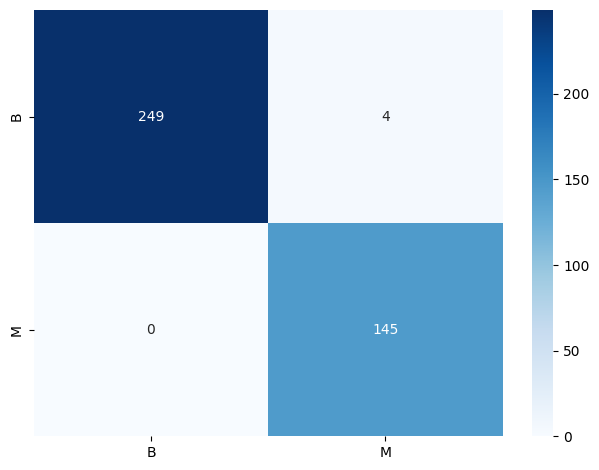

Test Set with Best Params Confusion matrix


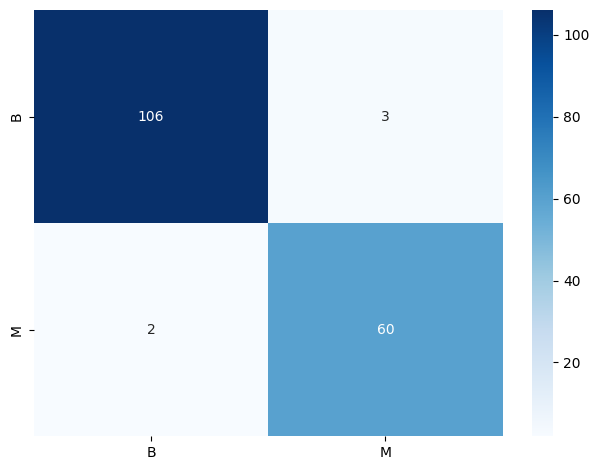

In [132]:
best_fit_test(knn_classifier_best, 5, "k-NN")


### k-Nearest Neighbors Learning Curve

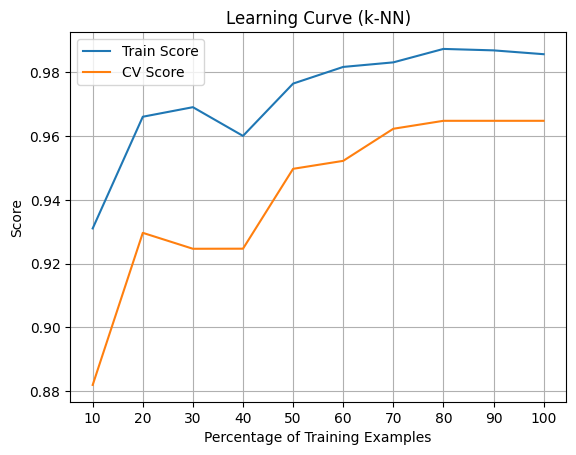

In [133]:
knn_classifier_learning = KNeighborsClassifier(
    n_neighbors=knn_classifier_best.best_params_['n_neighbors'],
    p=knn_classifier_best.best_params_['p'])
plot_learning_curve(knn_classifier_learning, "k-NN")


From the above image, we can see that with the percentage of training example increasing, although the train score and the CV score converges, there is a relatively big gap between the two. This suggests that the k-NN classifier is suffering from high variance and more data is needed.


## Time Comparison

In [134]:
classifiers: list[str] = ["DT", "ML NN", "SL NN", "Boosting", "SVM", "k-NN"]
y_ticks = np.arange(len(classifiers))
print(f"Training Time: {train_time}")
print(f"Inference Time: {infer_time}")
print(f"Accuracy: {classifier_accuracy}")

Training Time: [ 17.38112116 164.36352444 205.30450487 408.14514661   0.77608609
 407.75007176]
Inference Time: [0.00049424 0.00086498 0.00070548 0.48364687 0.00275159 0.07490921]
Accuracy: [0.96491228 0.99415205 0.99415205 0.98245614 0.98830409 0.97076023]


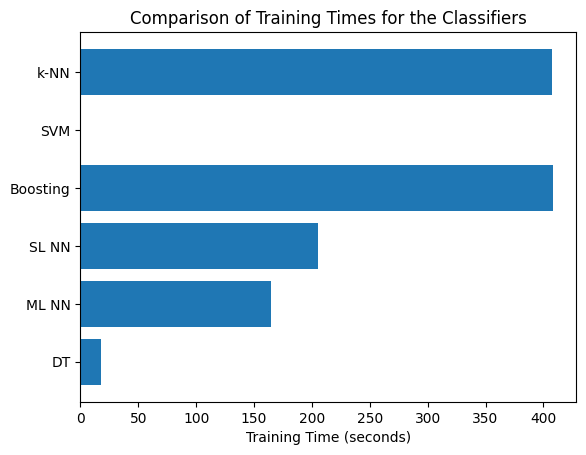

In [135]:
plt.figure()
plt.barh(y_ticks, train_time)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Training Times for the Classifiers')
plt.xlabel('Training Time (seconds)')
plt.savefig('images/breast_cancer/breast_cancer_training_time.png', dpi=300, bbox_inches='tight')
plt.show()

For the breast cancer dataset, Boosting and k-NN classifiers took the longest time. This is likely due to a large number neighbours for the knn classifier and a large number of weak learners for the boosting classifier.

Decision tree is trained the fastest as expected as the max depth of the tree is controlled using the max depth hyper-parameter and it's relatively low.

The neural network training times are also relatively high because the neural network needs to adjust the weight for each perceptron through backpropagation for gradient computation and the more layers/nodes there are in the NN, the longer it takes.

SVM takes the least amount of time. This is likely due to the fact that this dataset only has 569 rows and that makes solving the quadratic programming problem relatively easy.


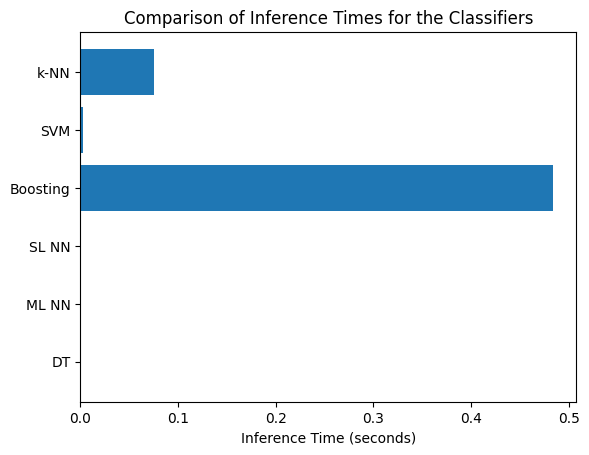

In [136]:
plt.figure()
plt.barh(y_ticks, infer_time)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Inference Times for the Classifiers')
plt.xlabel('Inference Time (seconds)')
plt.savefig('images/breast_cancer/breast_cancer_infer_time.png', dpi=300, bbox_inches='tight')
plt.show()

Inference time for decision trees is also low as expected since tree traversal is trivial.

For the k-NN classifier, since the distance to each neighbor has to be computed, it will take some time when the number of neighbours taken into account is high.

For Adaboost, as the inference is completed for each weak learner, it will take some time with a large number of weak leraners.

Both NN classifiers are relatively faster since the NN classifiers only need a single forward pass for each test case.

For SVM, the inference time is also low since SVM only uses linear function.


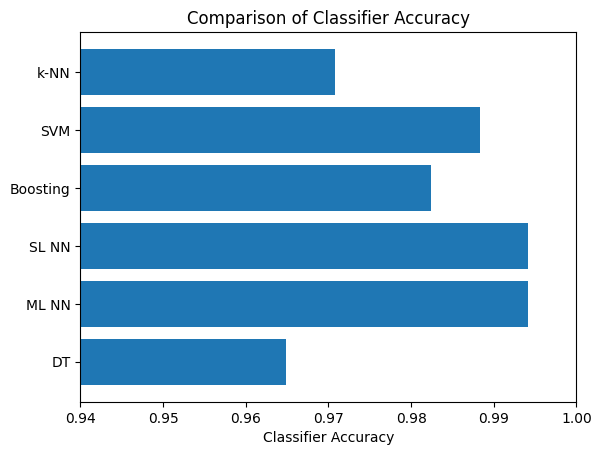

In [137]:
plt.figure()
plt.barh(y_ticks, classifier_accuracy)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Classifier Accuracy')
plt.xlabel('Classifier Accuracy')
plt.gca().set_xlim(0.94, 1.0)
plt.savefig('images/breast_cancer/breast_cancer_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

For the dry bean dataset, all classifier performs relatively similar (all above96% accuracy).

The discision tree classifier performs the poorest. This is likely due to the simple model and a low max depth.

Both neural networks perform the best since they are the most complex.

The SVM classifier performs quite well with the linear kernel. This is likely due to the fact that the dataset is linearly separable. This can also explain why neural networks perform almost perfectly since if the data space is linearly separable, the neural network will always find it in finite iterations.

For k-NN and adaboost classifiers, they also perform relatively well. However, their perform will still improve if more data is available.
